# Openpiv-python-gpu Tutorial

Use the following link to run this using GPUs from Google Colab.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ericyang125/openpiv-python-gpu/blob/master/Openpiv_Python_Tutorial_Basic.ipynb)

Ensure that GPU acceleration is enabled in Google Colab: Runtime > Change runtime type.


## Introduction


This tutorial will demonstrate how to use the GPU functionality of openpiv-python-gpu. OpenPIV will be installed to this VM and a single image pair will be processed.


## Function Documentation


### openpiv.gpu_process.gpu_piv_def(frame_a, frame_b, **pars)


    An iterative GPU-accelerated algorithm that uses translation and deformation of interrogation windows.

    At every iteration, the estimate of the displacement and gradient are used to shift and deform the interrogation
    windows used in the next iteration. One or more iterations can be performed before the the estimated velocity is
    interpolated onto a finer mesh. This is done until the final mesh and number of iterations is met.

    Algorithm Details
    -----------------
    Only window sizes that are multiples of 8 are supported now, and the minimum window size is 8.
    Windows are shifted symmetrically to reduce bias errors.
    The displacement obtained after each correlation is the residual displacement dc.
    The new displacement is computed by dx = dpx + dcx and dy = dpy + dcy.
    Validation is done by any combination of signal-to-noise ratio, mean, median
    Smoothn can be used between iterations to improve the estimate and replace missing values.

    References
    ----------
      Scarano F, Riethmuller ML (1999) Iterative multigrid approach in PIV image processing with discrete window offset.
          Exp Fluids 26:513–523
      Meunier, P., & Leweke, T. (2003). Analysis and treatment of errors due to high velocity gradients in particle image velocimetry.
          Experiments in fluids, 35(5), 408-421.
      Garcia, D. (2010). Robust smoothing of gridded data in one and higher dimensions with missing values.
          Computational statistics & data analysis, 54(4), 1167-1178.

    Parameters
    ----------
    frame_a, frame_b : array, 2D dtype=np.float32
        Two-dimensional array of integers containing grey levels of the first and second frames.
    window_size_iters : tuple or int
        Number of iterations performed at each window size
    min_window_size : tuple or int
        Length of the sides of the square deformation. Only supports multiples of 8.
    overlap_ratio : float
        The ratio of overlap between two windows (between 0 and 1).
    dt : float
        Time delay separating the two frames.
    mask : ndarray
        2D array of integers with values 0 for the background, 1 for the flow-field. If the center of a window is on a 0 value the velocity is set to 0.
    deform : bool
        Whether to deform the windows by the velocity gradient at each iteration.
    smooth : bool
        Whether to smooth the intermediate fields.
    nb_validation_iter : int
        Number of iterations per validation cycle.
    validation_method : {tuple, 's2n', 'median_velocity', 'mean_velocity', 'rms_velocity'}
        Method used for validation. Only the mean velocity method is implemented now. The default tolerance is 2 for median validation.
    trust_1st_iter : bool
        With a first window size following the 1/4 rule, the 1st iteration can be trusted and the value should be 1.

    Returns
    -------
    x : ndarray
        2D, the x-axis component of the interpolation locations, in pixels-lengths starting from 0 at left edge.
    y : ndarray
        2D, the y-axis component of the interpolation locations, in pixels starting from 0 at bottom edge.
    u : ndarray
        2D, the u velocity component, in pixels/seconds.
    v : ndarray
        2D, the v velocity component, in pixels/seconds.
    mask : ndarray
        2D, the boolean values (True for vectors interpolated from previous iteration).
    s2n : ndarray
        2D, the signal to noise ratio of the final velocity field.

    Other Parameters
    ----------------
    s2n_tol, median_tol, mean_tol, median_tol, rms_tol : float
        Tolerance of the validation methods.
    smoothing_par : float
        Smoothing parameter to pass to Smoothn to apply to the intermediate velocity fields.
    subpixel_method : {'gaussian', 'centroid', 'parabolic'}
        Method to estimate subpixel location of the peak. Gaussian is default if correlation map is positive. Centroid replaces default if correlation map is negative.
    sig2noise : bool
        whether the signal-to-noise ratio should be computed and returned. Setting this to False speeds up the computation significatly.
    sig2noise_method : {'peak2peak', 'peak2mean', None}
        Method of signal-to-noise-ratio measur. If None, no measure is performed.
    width : int
        Half size of the region around the first correlation peak to ignore for finding the second peak. Default is 2. Only used if sig2noise_method==peak2peak.

    Example
    -------
    >>> x, y, u, v, mask = gpu_piv_def(frame_a, frame_b, mask, min_window_size=16,window_size_iters=(2, 2), overlap_ratio=0.5, coarse_factor=2, dt=1, deform=True, smoothing=True, validation_method='median_velocity', validation_iter=2, trust_1st_iter=True, median_tol=2)


## Usage Example

In this example, a single pair of particle images is processed using the iterative GPU function openpiv.gpu_process.gpu_piv_def().
Cross-correlation is performed using 32 x 32 pixel windows, then twice at 16 x 16 pixel windows.
Both windows displacement and deformation are used.
Validation is performed using the median criterion.


### Install OpenPIV


In [1]:
# check that GPU is connected. Should say CUDA Version 1x.x
!nvidia-smi
!nvcc --version


Sat Jun 26 22:48:01 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Install PyCUDA.
!pip3 install pycuda

# Install scikit-CUDA.
!pip3 install scikit-CUDA

# Install other requirements which may already be fulfilled.
!pip3 install cython imageio numpy matplotlib setuptools

# Clone the repo.
!git clone https://github.com/ericyang125/openpiv-python-gpu.git

# Install OpenPIV extensions.
!cd openpiv-python-gpu && python3 setup.py build_ext --inplace


     |████████████████████████████████| 1.7MB 8.1MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 71kB 11.4MB/s 
     |████████████████████████████████| 81kB 11.6MB/s 
  Created wheel for pycuda: filename=pycuda-2021.1-cp37-cp37m-linux_x86_64.whl size=626902 sha256=e7af9ccab507d06d98a8530957e0d8f833959edaf8bd2951072215cf1df9ead4
  Stored in directory: /root/.cache/pip/wheels/d5/55/64/fd4dddcc5f1c25eebd90b5291c3769101dc978c70165685512
Successfully built pycuda
  Created wheel for pytools: filename=pytools-2021.2.7-py2.py3-none-any.whl size=60644 sha256=ea1291d75c8b953efe699b3153d43e1ae19d2c018f035b33c35585a8d3c680e7
  Stored in directory: /root/.cache/pip/wheels/a0/b5/e5/e65d25997fd77729b9aa214645add18688483e48bbcbab6ffc
Successfully built pytools
     |████████████████████████████████| 122kB 8.2MB/s 
Cloning into 'openpiv-python-gpu'...
remote: Enumerating objects:

### Load data

In [3]:
!wget https://raw.githubusercontent.com/ericyang125/openpiv-python-gpu/master/openpiv/examples/test1/exp1_001_a.bmp
!wget https://raw.githubusercontent.com/ericyang125/openpiv-python-gpu/master/openpiv/examples/test1/exp1_001_b.bmp


--2021-06-26 22:50:25--  https://raw.githubusercontent.com/ericyang125/openpiv-python-gpu/master/openpiv/examples/test1/exp1_001_a.bmp
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 190006 (186K) [image/bmp]
Saving to: ‘exp1_001_a.bmp’

exp1_001_a.bmp      100%[===================>] 185.55K  --.-KB/s    in 0.02s   

2021-06-26 22:50:26 (11.4 MB/s) - ‘exp1_001_a.bmp’ saved [190006/190006]

--2021-06-26 22:50:26--  https://raw.githubusercontent.com/ericyang125/openpiv-python-gpu/master/openpiv/examples/test1/exp1_001_b.bmp
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request se

### Python Example

In [4]:
import os
import sys
import numpy
import imageio as io
import matplotlib.pyplot as plt
%matplotlib inline

# Add OpenPIV to the python path.
sys.path.append(os.path.join(os.getcwd(), 'openpiv-python-gpu/'))

# Import the GPU module and the tools module.
import openpiv.gpu_process as gpu_process
import openpiv.tools as tools

# PIV parameters:
pars = {
'window_size_iters': (1, 2),
'min_window_size': 16,
'overlap_ratio': 0.5,
'dt': 1,
'mask': None,
'nb_validation_iter': 1,
'validation_method': 'median_velocity',
'trust_1st_iter': True
}

# The images are loaded using imageio.
frame_a = io.imread('exp1_001_a.bmp')
frame_b = io.imread('exp1_001_b.bmp')

# The velocity fields are computed.
x, y, u, v, mask, s2n = gpu_process.gpu_piv_def(frame_a, frame_b, **pars)

# Save the results to a text file.
tools.save(x, y, u, v, (1 - mask), 'exp1_001_gpu.txt')


/usr/local/lib/python3.7/dist-packages/skcuda/cublas.py:284: UserWarning: creating CUBLAS context to get version number
  warnings.warn('creating CUBLAS context to get version number')


//////////////////////////////////////////////////////////////////
ITERATION 0
[DONE]--Normalized residual : 7.493316940376897.

No validation--trusting 1st iteration.
Validation iteration 0:
Validating 23 out of 660 vectors (3.48%).
[DONE]

MATLAB:smoothn:SLowerBound
s = 0.029 : the lower bound for s has been reached. Put s as an input variable if required.
MATLAB:smoothn:SLowerBound
s = 0.029 : the lower bound for s has been reached. Put s as an input variable if required.
[DONE] -----> going to iteration 1.

//////////////////////////////////////////////////////////////////
ITERATION 1
[DONE]--Normalized residual : 2.6993301814597315.

Validation iteration 0:
Validating 207 out of 2790 vectors (7.42%).
[DONE]

[DONE] -----> going to iteration 2.

//////////////////////////////////////////////////////////////////
ITERATION 2
[DONE]--Normalized residual : 2.258069646451545.

Validation iteration 0:
Validating 184 out of 2790 vectors (6.59%).
[DONE]

///////////////////////////////////

Results:

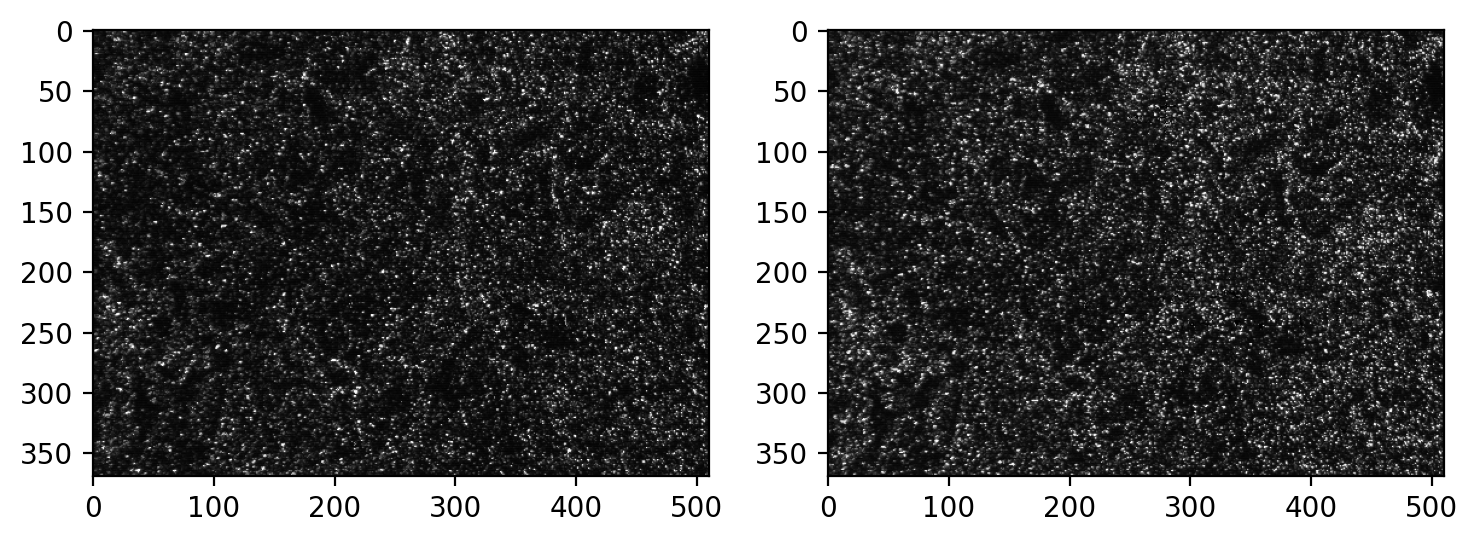

In [5]:
# Show the particle images.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7.5, 9), dpi=200, tight_layout=True)
ax1.imshow(frame_a, cmap='gray')
ax2.imshow(frame_b, cmap='gray')
plt.show()


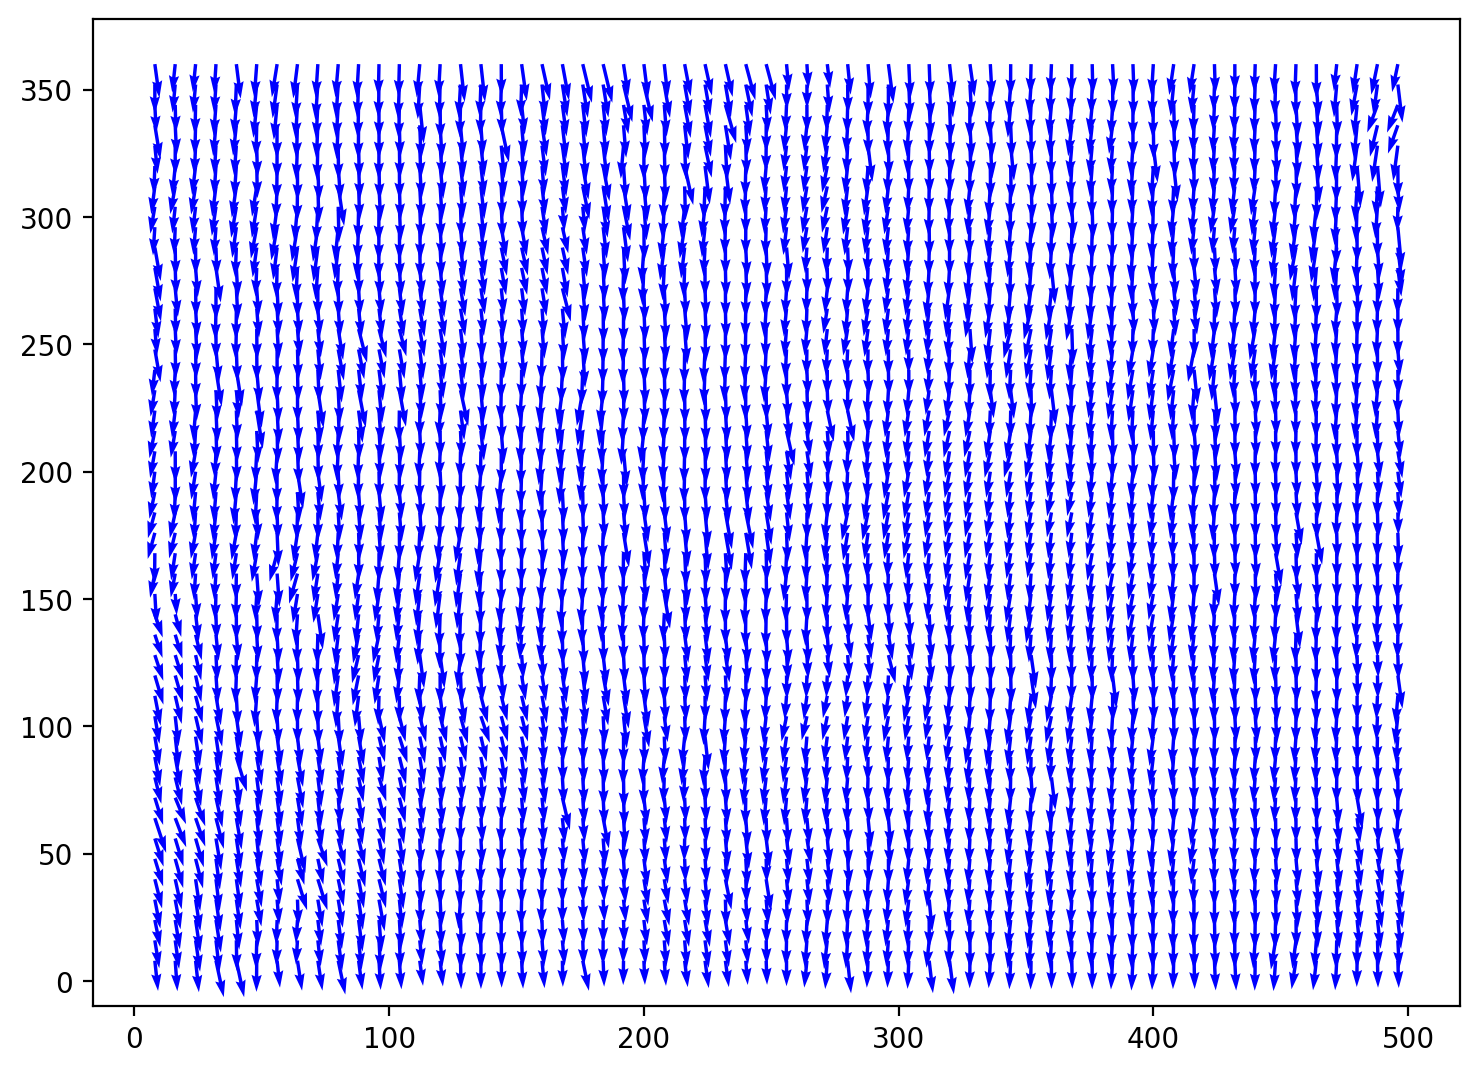

In [6]:
# The results can be visualized using the openpiv.tools module.
fig, ax = plt.subplots(figsize=(7.5, 9), dpi=200, tight_layout=True)
tools.display_vector_field('exp1_001_gpu.txt', ax=ax, scale=250, width=0.0025)
plt.show()
